In [1]:
import lin_reg_algos
import lin_reg_interactive
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm

In [2]:
sqrtm([[4,0],[0,4]])

array([[2., 0.],
       [0., 2.]])

In [3]:
from numpy.linalg import inv
from numpy.linalg import matrix_power

Algorithm:

1. Generate $X \sim \mathcal{N}(0, \Sigma)$
2. Estimate $\hat{\Sigma}$
3. Rescale X by $\hat{\Sigma}^{-\frac{1}{2}} \rightarrow \tilde{X}$
4. Run CoinPress on $\tilde{X}, y \rightarrow \tilde{\beta}$ 
5. Resclae $\tilde{\beta}$ by $\hat{\Sigma}^{-\frac{1}{2}} \rightarrow \hat{\beta}$

In [4]:
def generate_data_nonidentity_cov(n, d, underlying_dist, sigma):
    # sigma must be a dxd covariance matrix
    assert(len(sigma) == d)
    assert(len(sigma[0]) == d)
    
    X = np.random.multivariate_normal(np.zeros(d), sigma, n)
    X = np.array(X)

    # Generates a label vector from underlying distribution plus some noise
    y = []
    for i in range(n):
        y.append(np.dot(underlying_dist, X[i])[0] + np.random.normal(0, 1))
    y = np.array(y)

    return X, y

In [5]:
def generate_normal_underlying_dist(d, beta_mean, beta_var):
    """ generates beta, <X,beta> = y"""
    underlying_dist = np.random.normal(beta_mean, beta_var, (1, d))
    return np.array(underlying_dist)

In [6]:
data = generate_data_nonidentity_cov(10,2,generate_normal_underlying_dist(2,0,1),np.array([[10,0],[0,1]]))

In [126]:
def losses(n_values, d, iters, total_privacy_budget, loss_func, beta_mean=0, beta_var=1.0):
    
    priv_algo_losses = []
    nonpriv_algo_losses = []
    nonpriv_losses = []
    
    for n in n_values:
        priv_algo_losses_for_n = []
        nonpriv_algo_losses_for_n = []
        nonpriv_losses_for_n = []
            
        for i in range(iters):
            c = [0] * d
            r = 100 * np.sqrt(d)

            underlying_dist = generate_normal_underlying_dist(d, beta_mean, beta_var)
            sigma = np.eye(d)
            sigma[0][0] = 6
            sigma[0][1] = 2
            sigma[1][0] = 2
            
            x, y = generate_data_nonidentity_cov(n, d, underlying_dist, sigma)

            """ 2. Estimate Sigma Hat"""
            sigma_hat = lin_reg_algos.coinpress_linreg_covariance(x, d, total_budget = 2 * total_privacy_budget / 3)
#             print(sigma_hat)
#             print(sigma)

            """ 3. Rescale X by Sigma Hat"""
            uniform_norm_x = x @ inv(sqrtm(sigma))
            
            """ 4. Find Beta Tilde"""
            priv_beta_tilde = lin_reg_algos.coinpress_linreg(uniform_norm_x, y, underlying_dist, c, r, total_privacy_budget / 3)
            nonpriv_beta_tilde = lin_reg_interactive.linreg_closed_form_solution(uniform_norm_x, y)
            
            """ 5. Rescale Beta Tilde by Sigma Hat"""
            priv_algo_beta_hat = inv(sqrtm(sigma_hat)) @ priv_beta_tilde
            priv_algo_losses_for_n.append(loss_func(priv_algo_beta_hat, underlying_dist[0], d))
            
            nonpriv_algo_beta_hat = inv(sqrtm(sigma)) @ nonpriv_beta_tilde
            nonpriv_algo_losses_for_n.append(loss_func(nonpriv_algo_beta_hat, underlying_dist[0], d))
            
#             priv_beta_hat = lin_reg_algos.coinpress_linreg(x,y)
            
            nonpriv_beta_hat = lin_reg_interactive.linreg_closed_form_solution(x, y)
            nonpriv_losses_for_n.append(loss_func(nonpriv_beta_hat, underlying_dist[0], d))
             
            
        """ finds the mean loss for the current n for each of the following scenarios """
        
        nonpriv_algo_losses_for_n = np.array(nonpriv_algo_losses_for_n)
        nonpriv_algo_losses.append(np.mean(nonpriv_algo_losses_for_n))
        
        priv_algo_losses_for_n = np.array(priv_algo_losses_for_n)
        priv_algo_losses.append(np.mean(priv_algo_losses_for_n))
        
        nonpriv_losses_for_n = np.array(nonpriv_losses_for_n)
        nonpriv_losses.append(np.mean(nonpriv_losses_for_n))
        
    # TODO : add title, make y axis 0 -> 2, make sure label in top right corner / out of the way!
    plt.plot(n_values, nonpriv_algo_losses, 'r', label='Closed-Form Solution Using Algorithm')
    plt.plot(n_values, priv_algo_losses, 'y', label='Private Solution Using Algorithm')
    plt.plot(n_values, nonpriv_losses, 'b', label='Closed-Form Solution')
    plt.legend(loc="upper right")
    axes = plt.gca()
    axes.set_ylabel('Population Loss')
    axes.set_xlabel('n')
    axes.set_title('Extended Algorithm: Non-Identity Sigma d = 5')
    axes.set_ylim([0.9,2])

    return nonpriv_algo_losses, nonpriv_losses, priv_algo_losses

([1.0054560114416968,
  1.0058491722982117,
  0.9941931308181113,
  1.0201195755937762,
  1.0045463284577238,
  1.0011786494100212,
  1.004434319722617,
  1.0044414329919384],
 [1.0077054203584959,
  1.016631327951829,
  1.0091890876795702,
  0.996456421829637,
  0.9921931508133918,
  0.998170721885171,
  1.0028759153335765,
  0.9939431080411105],
 [2.949036980486592,
  1.7736292673110161,
  1.3044995969908706,
  1.1127536174889865,
  1.1035393753539955,
  1.077185954870994,
  1.0504194039311818,
  1.0679535336417996])

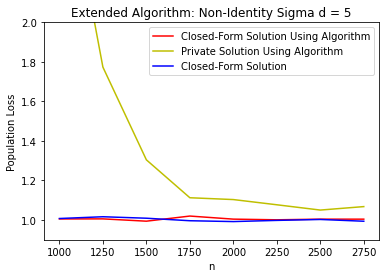

In [128]:
losses(range(1000,3000,250), 5, 30, 0.5, lin_reg_interactive.loss)

In [49]:
[[4,0],[0,4]]
np.array([[2,0],[0,2]])@np.array([[2,0],[0,2]])

array([[4, 0],
       [0, 4]])